# Conic Formulation of Unbalanced GW

Implement the bi-linear programming formulation of unbalanced Gromov-Wasserstein.

_Warning:_ you need to install `progressbar2` apparently with `pip install progressbar2`. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import progressbar as pb

In [2]:
def distmat(x,y):
    return np.sqrt( np.abs(np.sum(x**2,0)[:,None] + np.sum(y**2,0)[None,:] - 2*x.transpose().dot(y) ) )

# Conic Unbalanced Gromov-Wasserstein (CGW)

In [3]:
# un-even size for debugging
n = 6
m = 5
k = 10 # angle samples
l = 11 

# even size for production
n = 6
m = n
# angle samples
k = 10 
l = k 

Generate two measures in $\mathbb{R}^d$ to test the code.

In [4]:
normalize = lambda a: a/np.sum(a)
# random histograms
a = normalize(np.random.rand(n))
b = normalize(np.random.rand(m))
d = 2 # dimension
x = np.random.rand(d,n)
y = np.random.rand(d,m)

Compute pairwise distance matrices $D_X(x,x') = \|x-x'\|_2$.

In [5]:
DX = distmat(x,x)
DY = distmat(y,y)

Discretized radius on the cones. *TODO:* select a larger radius since after the tested mass varies.

In [6]:
rmax = np.sqrt( np.max(a) )
smax = np.sqrt( np.max(b) )
R = np.linspace(0,rmax,k)
S = np.linspace(0,smax,l)

Compute the GW kernel 
$$
    K(x,r,x',r',y,s,y',s') 
    \triangleq \tau \Big[ (rr')^2 + (ss')^2 - 2 r's' e^{ - \frac{|D_X(x,x')-D_Y(y,y')|^2}{2\tau} } \Big]
$$

In [7]:
tau = 1
def GH(x,r,y,s): return tau * ( r**2+s**2 - 2*r*s*np.exp( -np.abs(x-y)**2/(2*tau) ) )
# form the 8D kernel (x,r,x',r' ; y,s, y',s')
def CGW_Kernel(DX,DY):
    return GH( DX[:,None,:,None, None,None,None,None], \
        R[None,:,None,None, None,None,None,None]*R[None,None,None,:, None,None,None,None], \
        DY[None,None,None,None, :,None,:,None], \
        S[None,None,None,None, None,:,None,None]*S[None,None,None,None, None,None,None,:])
# operator to apply K to a matching alpha, i.e. compute K*alpha
def apply_K(K,alpha):
    return np.sum( K * alpha[None,None,:,:, None,None,:,:], (2,3,6,7), keepdims=True ).squeeze()
# test
K = CGW_Kernel(DX,DY)
Alpha = np.random.rand( n,k, m,l )
apply_K(K,Alpha).shape

(6, 10, 6, 10)

Solve the conic GW problem, which is a bilinear non-convex problem, by alernating minimization
$$
    \min_{\alpha \geq 0} \{
        \langle K \alpha, \alpha \rangle
        :
        \sum_{k,j,\ell} \alpha_{i,k,j,l} r_{k}^2 = a_i, 
        \sum_{i,k,\ell} \alpha_{i,k,j,l} s_{\ell}^2 = b_j.         
        \}
$$

We first implement its linearized version, which is a conic unbalanced OT problem (CUW) associated to a 4-D cost tensor 
$$
    \min_{\alpha \geq 0} \{
        \langle C, \alpha \rangle
        :
        \sum_{k,j,\ell} \alpha_{i,k,j,l} r_{k}^2 = a_i, 
        \sum_{i,k,\ell} \alpha_{i,k,j,l} s_{\ell}^2 = b_j.         
        \}
$$

In [8]:
# CVXPY problem setup 
RR = np.tile(R, (n,1))
SS = np.tile(S, (m,1))
# variable
alpha = cp.Variable((n*k,m*l))
alpha1 = cp.Variable((n,k))
alpha2 = cp.Variable((m,l))
# constraints
U = [0 <= alpha, 
        alpha1==cp.reshape(cp.sum(alpha, axis=1),(k,n)).T, \
        alpha2==cp.reshape(cp.sum(alpha, axis=0),(l,m)).T, \
        cp.sum( cp.multiply(alpha1, RR**2), 1)==a, \
        cp.sum( cp.multiply(alpha2, SS**2), 1)==b \
    ]
def Solve_CUW(C):
    C = C.reshape(n*k,m*l)
    objective = cp.Minimize( cp.sum(cp.multiply(alpha,C)) )
    prob = cp.Problem(objective, U)
    result = prob.solve(verbose=False)
    return alpha.value.reshape(n,k,m,l)

We now solve the blinear problem by alternating minimization.

100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (7 of 7) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


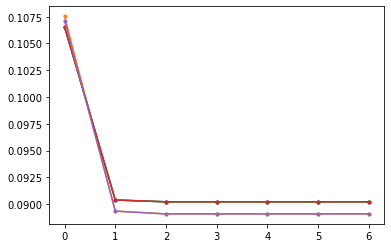

In [9]:
# alternate minimization
def Solve_CGW(K,niter=10,nruns=1,verbose=True):
    CGWcost = np.zeros((niter,nruns))
    for kt in range(nruns):
        # initialize matching
        Alpha = np.random.rand( n,k, m,l )
        Alpha = Alpha / np.sum(Alpha.flatten())
        H = range(niter)
        if verbose:
            H = pb.progressbar(H)
        for it in H:
            Alpha = Solve_CUW( apply_K(K,Alpha) )
            CGWcost[it,kt] = np.sum( apply_K(K,Alpha).flatten() * Alpha.flatten() )
    return ( np.min(CGWcost.flatten()), CGWcost )

nruns = 5 # different initializations
niter = 7
cost,CGWcost = Solve_CGW(K,niter,nruns)
plt.plot(CGWcost, '.-');

TODO: find a way to convert a conic measure $\alpha$ into a classical GW matching $\pi$.

In [10]:
def dilation(x,r,y,s): return np.sqrt( r*s*np.exp( -abs(x-y)**2/(2*tau) ) )
# eta = dilation( R[None,:,None,None], S[None,None,None,:], D[:,None,:,None] )
# multiply by eta^2 and then marginalize on (x,y)
# pi = np.sum( np.sum( Alpha * eta**2, 1, keepdims=True), 3, keepdims=True).squeeze()
# plt.imshow(pi)

# Compare with Unbalanced Gromov Wasserstein (UGW)
We now consider the penalized fromulation
$$
    \min_{\pi \geq 0} \langle Q \pi, \pi \rangle 
    + \tau \text{KL}^{\otimes 2}(\pi_1|a)
    + \tau \text{KL}^{\otimes 2}(\pi_2|b)
$$
where the coupling is now $\pi \in \mathbb{R}_+^{n \times m}$ and the quadratic form is 
$$
    Q((x,y),(x',y')) \triangleq | D_X(x,x') - D_Y(y,y') |^2
$$
where the quadratic 

In [11]:
import sys
sys.path.append("../")
import torch
# from solver.vanilla_sinkhorn_solver import VanillaSinkhornSolver
from solver.batch_stable_sinkhorn_solver import BatchStableSinkhornSolver
from solver.utils import generate_measure
torch.set_printoptions(8)
import itertools

In [12]:
epsilon = 0.01
# solv = VanillaSinkhornSolver(nits_plan=1, nits_sinkhorn=300, gradient=False, tol_plan=1e-5, tol_sinkhorn=1e-5,
#                              eps=epsilon, rho=float(tau))
solv = BatchStableSinkhornSolver(nits_plan=1, nits_sinkhorn=300, gradient=False, tol_plan=1e-5, tol_sinkhorn=1e-5,
                             eps=epsilon, rho=float(tau))
def Solve_UGW(DX,DY,a,b,nruns=5,verbose=True):
    DX1 = torch.from_numpy(DX).type(torch.FloatTensor)
    DY1 = torch.from_numpy(DY).type(torch.FloatTensor)
    a1 = torch.from_numpy(a).type(torch.FloatTensor)
    b1 = torch.from_numpy(b).type(torch.FloatTensor)
    UGWcost = np.zeros(nruns)
    H = range(nruns)
    if verbose:
        H = pb.progressbar(H)            
    for kt in H:
        pi0 = torch.rand((n,m))
        pi0 = pi0/torch.sum(pi0)
    
#         # For vanilla solver
#         pi,gamma = solv.alternate_sinkhorn(a1[None,:], DX1[None,:,:], b1[None,:], DY1[None,:,:], init=pi0[None,:,:])
#         UGWcost[kt] = solv.ugw_cost(pi, gamma, a1, DX1, b1, DY1)

        # For stable solver
        pi = solv.ugw_sinkhorn(a1[None,:], DX1[None,:,:], b1[None,:], DY1[None,:,:], init=pi0[None,:,:])
        UGWcost[kt] = solv.ugw_cost(pi, pi, a1[None,:], DX1[None,:,:], b1[None,:], DY1[None,:,:]).item()
        
    UGWcost_no_nan = UGWcost[~np.isnan(UGWcost)]
    if UGWcost_no_nan.size==0:
        cost = np.nan
    else:
        cost = np.min(UGWcost_no_nan)
    return (cost , UGWcost ) # np.min(UGWcost[~np.isnan(UGWcost)])

In [13]:
cost, UGWcost = Solve_UGW(DX,DY,a,b,nruns,verbose=True)
print( str('UCG = ') + str(np.sort( UGWcost )) )
print( str('CCG = ') + str(np.sort( CGWcost[-1,:] )) )

100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


UCG = [0.21672302 0.21935137 0.23406395 0.24053515 0.24320947]
CCG = [0.08907811 0.08907811 0.09020922 0.09020922 0.09020922]


# Randomized tests

*TODO:* impose a maximum value for the histograms in order to avoid going above the max radius of the cones.

In [ ]:
ntests = 20
CGWcost = np.zeros(ntests)
UGWcost = np.zeros(ntests)
for kt in pb.progressbar(range(ntests)):
    # generate random points
    a = normalize(np.random.rand(n))
    b = normalize(np.random.rand(m))
    x = np.random.rand(d,n)
    y = np.random.rand(d,m)
    # associated kernel
    DX = distmat(x,x)
    DY = distmat(y,y)
    K = CGW_Kernel(DX,DY)
    # run CGW
    CGWcost[kt],CGWcost_list = Solve_CGW(K,niter,nruns,verbose=False)    
    UGWcost[kt],UGWcost_list = Solve_UGW(DX,DY,a,b,nruns,verbose=False)

  5% (1 of 20) |#                        | Elapsed Time: 0:00:03 ETA:   0:01:00

In [ ]:
plt.plot( CGWcost / UGWcost, '.');

In [ ]:
plt.hist( CGWcost / UGWcost, np.linspace(0,1.2,12) );

# Sanity checks

## Control for distinguishing pairs of diracs

In [ ]:
#Values
n = 1
m = 1
k = 10 # angle samples
l = 11

# generate random points
a = normalize(np.random.rand(1))
b = normalize(np.random.rand(1))
x = np.random.rand(d,1)
y = np.random.rand(d,1)
# associated kernel
DX = distmat(x,x)
DY = distmat(y,y)
K = CGW_Kernel(DX,DY)
# run CGW
CGWcost,CGWcost_list = Solve_CGW(K,niter,nruns,verbose=False)    
UGWcost,UGWcost_list = Solve_UGW(DX,DY,a,b,nruns,verbose=False)
print(f"Theoretical value = {(a-b)**2} / CGWcost = {CGWcost} / UGWcost = {UGWcost}")